## Jared Connolly
4775391

In [83]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits 
from matplotlib import rc
from IPython.display import display, Math, Latex

# Define tridiagonal solver

def tridiagonalSolver(a,b,c,d):
    # factorization coefficients
    m = np.array([]); l = np.array([])
    m = np.append(m, a[0])
    n = int(a.size)
    for j in range(n-1):
        l = np.append(l, c[j] / m[j] )
        m = np.append(m, a[j+1]-l[j]*b[j])
    
    # Forward substitution on Ly = d
    y = np.array([])
    y = np.append(y, d[0])
    for j in range(1,n):
        y = np.append(y, d[j]-l[j-1]*y[j-1])

    # Backward substitution to solve Ux = y
    z = np.zeros(n)
    z[n-1] = y[n-1] / (m[n-1]+0.0)
    
    for j in range(n-2, -1, -1):
        z[j] = (y[j]-b[j]*z[j+1])/m[j]
        
    return z

# OUTPUT: the vector Z of dimension (n-1 x 1) which are the second derivatives of the domain nodes z_j for j = 0,...,n 
# from the equation Az = d

In [84]:
# Part a

D=0.003;maxX=1;
N=60; M=30; T=10.0; 

# Central difference approximation of 2nd derivative of U^n or U* right hand side wrt t
def D2(ujm1,uj,ujp1,alpha): # Uj-1, Uj, Uj+1, alpha
    cent_diff = alpha*ujp1 +(1-2*alpha)*uj + alpha*ujm1
    return(cent_diff)

# Initial value of ODE at initial time step, t = 0
def u_0(x,y):
    return (np.sin(np.pi*x)*np.sin(np.pi*y)) 

# ADI
def ADI(u_0,D,D2,maxX,M,N,T):
    deltax = maxX/M # Delta x,y
    deltat = T/N 
    r = deltat*D/(2*deltax**2) # coefficient input of tridiagonal matrices wrt x 
    U = np.full([N+1, M+1,M+1], 0.0) # initialize approximation of NxLxM matrix w/ Dirichlet boundary conditions
    x,y = [j*h for j in range(M+1)],[j*deltax for j in range(M+1)]
    X,Y = np.meshgrid(x,y)
    U[0,:,:] = u_0(X,Y) # initialize conditions
    uStar = np.zeros((M+1,M+1)) # approximations at time n
    a = np.empty(M-1); a.fill(1+2*r)
    b = np.full([M-2],-r)
    for n in range(N):
        for i in range(1,M):
                  # Now, solving for u* 
            u_nl = [ D2(U[n,j-1,i],U[n,j,i],U[n,j+1,i],r) for j in range(1,M)]
            uStar[1:-1,i] = tridiagonalSolver(a,b,b,u_nl)  
        
        for i in range(1,M):
                  # And solving for u^n+1
            d = [ D2(uStar[i,l-1],uStar[i,l],uStar[i,l+1],r) for l in range(1,M)]
            U[n+1,i,1:-1] = tridiagonalSolver(a,b,b,d)
            
    return X,Y,U


The ADI method is unconditionally stable therefore numerical stability does NOT play a role in our values of delta t and delta x

In [85]:
# Part b
deltax = maxX/20
X20,Y20,U20 = ADI(u_0,D,D2,maxX,20,N,T)
X40,Y40,U40 = ADI(u_0,D,D2,maxX,40,N,T)
X80,Y80,U80 = ADI(u_0,D,D2,maxX,80,N,T)

#plotADI(X50,Y50,U50,T,N, numPlots, elevation, rotation)
u20,u40,u80 = U20[30,10,10],U40[30,20,20],U80[30,40,40]
log2q = np.log2((u40-u20)/(u80-u40))

Latex("$\\mathcal O(2)= %f \\approx \\log(2^2)$" %np.round(log2q,2))
Latex("then ADI is of order $\\mathcal O(\\Delta x)^2$")

<IPython.core.display.Latex object>

In [86]:
# Part c

def plotADI(X,Y,U,T,N,deltax, numPlots, elevation, rotation):
    skipEvery = round(N/numPlots); deltat=T/N # delta t
    
    for i in range(0,N+1,30):
        fig = plt.figure()
        ax = fig.add_subplot (111, projection = '3d')
        ax.plot_surface(X, Y, U[i,:,:], 
                        rstride=1, cstride=1,cmap='viridis',edgecolor='none')
        ax.set_xlabel("$y$")
        ax.set_ylabel("$x$")
        ax.set_zlabel('$U(x,y)$')
        ax.auto_scale_xyz([0, 1], [0, 1], [0, 1])  
        title="t = %i"
        ax.set_title(title %(deltat*i))
        ax.view_init(elevation,rotation)
        plt.tight_layout()
        plt.show()

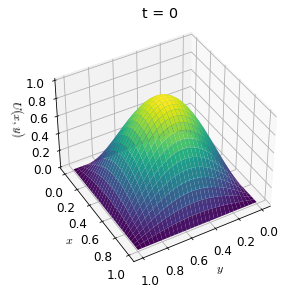

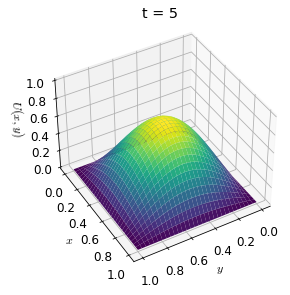

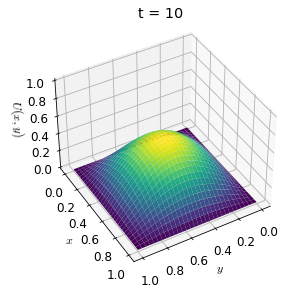

In [87]:
numPlots=3;deltax=maxX/M # delta x and delta y
elevation, rotation = 40,60
X,Y,U = ADI(u_0,D,D2,maxX,M,N,T)
plotADI(X,Y,U,T,N, deltax, numPlots, elevation, rotation)

In [88]:
# Part d

I would choose ADI. ADI would be the better choice because ADI gives tridiagonal matrices to solve in the 2D case whereas Crank-Nicolson does not in 2D heat equations. With ADI, the equations that have to be solved in each step have a simpler structure and can be done with tridiagonal matrix algorithms. Moreover, Crank-Nicolson results in a very complicated set of equations in multiple dimensions and thus it more expensive to solve than with a tridiagonal matrix. 